In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import firwin

<h3 style="text-align: center;">Global Config Variables</h3>

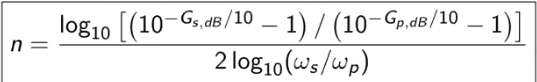 
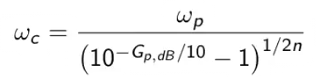
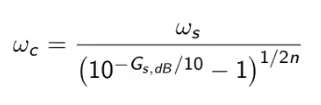
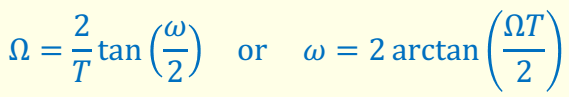

In [ ]:
def butterworth_order_cutoff(wp_hz, ws_hz, Ap_db, As_db, fs):
    # ---------- Prewarp digital frequencies ----------
    Omega_p = 2 * fs * np.tan(np.pi * wp_hz / fs)
    Omega_s = 2 * fs * np.tan(np.pi * ws_hz / fs)

    # ---------- Ripple factors ----------
    eps2 = 10**(Ap_db / 10) - 1
    As2  = 10**(As_db / 10) - 1

    # ---------- Order calculation ----------
    N = np.log10(As2 / eps2) / (2 * np.log10(Omega_s / Omega_p))
    N = int(np.ceil(N))

    # ---------- Cutoff frequency ----------
    Omega_cp = Omega_p / (eps2 ** (1 / (2 * N)))
    Omega_cs = Omega_s / (As2  ** (1 / (2 * N)))
    # Omega_c  = np.sqrt(Omega_cp * Omega_cs)
    Omega_c  = omega_cp

    # ---------- Back to digital frequency ----------
    fc_hz = (fs / np.pi) * np.arctan(Omega_c / (2 * fs))

    return N, fc_hz

In [3]:
fs = 7000

wp = 1500      # passband edge (Hz)
ws = 3000      # stopband edge (Hz)
Ap = 0.15         # passband loss (dB)
As = 60        # stopband attenuation (dB)

In [4]:
USE_TEST_SIGNAL = True        # True = synthetic tone, False = WAV
TEST_SIGNAL_FREQ = 500         # Hz
TEST_SIGNAL_DUR  = 2.0         # sec
fs = 8000

CUTOFF_HZ = 1000                # Hz
FILTER_ORDER = 1              # for IIR
FIR_TAPS = 101                 # for FIR
USE_IIR = True                 # True=IIR, False=FIR
FILTER_TYPE = "lowpass"        # "lowpass" or "highpass"

ADD_NOISE = True               # enable noise addition
NOISE_TYPE = "Hum"             # "White", "Hum", "None"
NOISE_LEVEL = 1.0                # relative noise power (0.0–1.0)
NOISE_FREQUENCY = 60

AUDIO_FILE = "audio1.wav"

<h3 style="text-align: center;">Utilities</h3>

In [5]:
def add_noise(audio, sr, noise_t, noise_lvl, noise_freq=60):
    if noise_t == 'None' or noise_lvl <= 0:
        return audio

    sig_std = np.sqrt(np.mean(audio**2))
    noise_amp = noise_lvl * sig_std
    # 60 Hz hum tone
    t = np.arange(len(audio)) / sr
    noise = noise_amp * np.sin(2*np.pi*noise_freq*t)

    return audio + noise

<h3 style="text-align: center;">Butterworth IIR</h3>

The provided Python code implements the design of a Butterworth IIR filter using the bilinear transform and then applies the resulting filter coefficients using the direct form difference equation.
Here is the corresponding mathematical notation for the key parts of the functions.
1. Analog Prototype Pole Calculation (_butter_analog_poles)
The function calculates the poles $p_k$ of the normalized analog Butterworth filter (where the cutoff frequency $\Omega_c = 1$ rad/s). The poles are located on the unit circle in the $ s $-plane.
For a filter of order $\text{order}$, the poles $p_k$ are given by:

$$p_k = e^{j \theta_k}, \quad \text{for } k = 1, 2, \ldots, \text{order}$$
where the angles $\theta_k$ are:

$$\theta_k = \frac{(2k + \text{order} - 1) \pi}{2 \cdot \text{order}}$$
2. Digital IIR Filter Design (design_butter_iir)
This function converts the analog prototype poles to digital filter coefficients $b$ and $a$ using the bilinear transform with frequency pre-warping.
a. Pre-warping and Analog Cutoff Frequency ($\Omega_c$)
The digital cutoff frequency $f_{\text{cutoff}}$ (in Hz) is pre-warped to the analog cutoff frequency $\Omega_c$ (in rad/s) using the sampling frequency $f_s = \text{sr}$:

$$\Omega_c = 2 f_s \tan \left( \frac{\pi f_{\text{cutoff}}}{f_s} \right)$$
b. Un-normalized Analog Poles ($p_{\text{analog}}$) and Denominator ($a_s$)
The normalized poles $p_{\text{proto}, k}$ are scaled by the analog cutoff frequency $\Omega_c$:

$$p_{\text{analog}, k} = p_{\text{proto}, k} \cdot \Omega_c$$
The coefficients $a_s$ of the analog denominator polynomial $A_s(s)$ are then found:

$$A_s(s) = \prod_{k=1}^{\text{order}} (s - p_{\text{analog}, k}) = a_{s, 0} s^{\text{order}} + a_{s, 1} s^{\text{order}-1} + \cdots + a_{s, \text{order}}$$
where $a_s$ is the vector of coefficients $[a_{s, 0}, a_{s, 1}, \ldots, a_{s, \text{order}}]$.
c. Bilinear Transformation (Poles and Zeros)
The analog poles $p_{\text{analog}, k}$ are converted to digital poles $z_{\text{poles}, k}$ using the bilinear transform:

$$z_{\text{poles}, k} = \frac{1 + p_{\text{analog}, k} / (2 f_s)}{1 - p_{\text{analog}, k} / (2 f_s)}$$
The digital zeros $z_{\text{zeros}, k}$ are placed at:

$$z_{\text{zeros}, k} = \begin{cases} -1 & \text{if } \text{filter\_type} = \text{'lowpass'} \\ 1 & \text{if } \text{filter\_type} = \text{'highpass'} \end{cases} \quad \text{for } k = 1, 2, \ldots, \text{order}$$
d. Digital Coefficients ($a$ and $b$) and Normalization
The denominator coefficients $a$ are found from the digital poles $z_{\text{poles}}$:

$$A(z) = \prod_{k=1}^{\text{order}} (z - z_{\text{poles}, k}) = a_0 z^{\text{order}} + a_1 z^{\text{order}-1} + \cdots + a_{\text{order}}$$
The un-normalized numerator coefficients $b_{\text{unnorm}}$ are found from the digital zeros $z_{\text{zeros}}$:

$$B_{\text{unnorm}}(z) = \prod_{k=1}^{\text{order}} (z - z_{\text{zeros}, k}) = b_{\text{unnorm}, 0} z^{\text{order}} + b_{\text{unnorm}, 1} z^{\text{order}-1} + \cdots + b_{\text{unnorm}, \text{order}}$$
The final numerator coefficients $b$ are normalized for unity gain at a specific frequency (DC for lowpass, Nyquist for highpass). The normalization factor $K$ is:

$$K = \frac{A(z_{\text{eval}})}{B_{\text{unnorm}}(z_{\text{eval}})}$$
where the evaluation point $z_{\text{eval}}$ is:

$$z_{\text{eval}} = \begin{cases} 1 & \text{if lowpass (DC gain)} \\ -1 & \text{if highpass (Nyquist gain)} \end{cases}$$
The final numerator coefficients $b$ are:

$$b = K \cdot b_{\text{unnorm}}$$
3. Apply Filter Direct Form I/II (apply_filter_direct)
This function applies the IIR filter defined by the coefficients $b$ and $a$ to an input signal $x$. The transfer function $H(z)$ is:

$$H(z) = \frac{Y(z)}{X(z)} = \frac{B(z)}{A(z)} = \frac{b_0 + b_1 z^{-1} + \cdots + b_M z^{-M}}{a_0 + a_1 z^{-1} + \cdots + a_N z^{-N}}$$
where $M = \text{len}(b) - 1$ and $N = \text{len}(a) - 1$.
The function implements the difference equation for the IIR filter, which relates the output sample $y[n]$ to the current and past input samples $x[n-i]$ and past output samples $y[n-j]$.
The general difference equation solved for $y[n]$ is:

$$y[n] = \frac{1}{a_0} \left( \sum_{i=0}^{M} b_i x[n-i] - \sum_{j=1}^{N} a_j y[n-j] \right)$$
Assuming zero initial conditions ($x[k]=0$ and $y[k]=0$ for $k < 0$).
In the provided code, the coefficients $a$ and $b$ are indexed from $0$, so $a_0 = a[0]$, $b_i = b[i]$, and $a_j = a[j]$. The implemented difference equation is:

$$y[n] = \frac{1}{a[0]} \left( \sum_{i=0}^{M} b[i] x[n-i] - \sum_{j=1}^{N} a[j] y[n-j] \right)$$


In [6]:
def _butter_analog_poles(order):
    poles = []
    for k in range(1, order+1):
        theta = (2*k + order -1) * np.pi / (2*order)
        poles.append(np.exp(1j*theta))
    return np.array(poles)


def design_butter_iir(filter_type, cutoff_hz, sr, order):
    if cutoff_hz <= 0 or cutoff_hz >= sr/2:
        raise ValueError('cutoff must be within (0, Nyquist)')

    fs = float(sr)
    Omega_c = 2*fs * np.tan(np.pi*cutoff_hz/fs)
    # Omega_c = np.tan(np.pi*cutoff_hz/fs)

    p_proto = _butter_analog_poles(order)
    p_analog = p_proto * Omega_c

    a_s = np.real_if_close(np.poly(p_analog))

    # Bilinear transform
    z_poles = (1 + p_analog/(2*fs)) / (1 - p_analog/(2*fs))
    # z_poles = (1 + p_analog) / (1 - p_analog)

    # zeros
    if filter_type == 'lowpass':
        z_zeros = np.array([-1.0]*order)
    else:  # highpass
        z_zeros = np.array([1.0]*order)

    a = np.real_if_close(np.poly(z_poles))
    b = np.real_if_close(np.poly(z_zeros))

    z_eval = 1.0 if filter_type=='lowpass' else -1.0
    num = np.polyval(b, z_eval)
    den = np.polyval(a, z_eval)
    b = b * (np.real(den/num))

    return b.real, a.real, a_s.real, p_analog

def apply_filter_direct(b, a, x):
    b = np.asarray(b, dtype=float)
    a = np.asarray(a, dtype=float)
    x = np.asarray(x, dtype=float)

    M = len(b) - 1
    N = len(a) - 1
    y = np.zeros_like(x, dtype=float)

    for n in range(len(x)):
        acc = 0.0
        for i in range(M + 1):
            if n - i >= 0:
                acc += b[i] * x[n - i]
        for j in range(1, N + 1):
            if n - j >= 0:
                acc -= a[j] * y[n - j]
        y[n] = acc / a[0]

    return y

<h3 style="text-align: center;">FIR</h3>

In [7]:
def design_fir(filter_type, cutoff, sr, numtaps=101):
    nyq = sr/2.0
    wn = cutoff / nyq
    pass_zero = True if filter_type == "lowpass" else False

    taps = firwin(numtaps, wn, pass_zero=pass_zero)
    return taps, 1.0

<h3 style="text-align: center;">Generate Signal</h3>


In [8]:
if USE_TEST_SIGNAL:
    t = np.linspace(0, TEST_SIGNAL_DUR, int(fs * TEST_SIGNAL_DUR), endpoint=False)
    audio = 0.8 * np.sin(2*np.pi * TEST_SIGNAL_FREQ * t)
else:
    audio, fs = sf.read(AUDIO_FILE)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    audio = audio.astype(float)


audio_noisy = add_noise(audio, fs, NOISE_TYPE, NOISE_LEVEL, NOISE_FREQUENCY)
sf.write("audio_noisy.wav", audio_noisy, fs)
print("Saved filtered.wav")

# Design filter
# FILTER_ORDER, CUTOFF_HZ = butterworth_order_cutoff(wp, ws, Ap, As, fs)
if USE_IIR:
    b, a, a_s, p_an = design_butter_iir(FILTER_TYPE, CUTOFF_HZ, fs, FILTER_ORDER)
else:
    b, a = design_fir(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)

# Apply filter
filtered = apply_filter_direct(b, a, audio_noisy)
filtered = filtered / (np.max(np.abs(filtered)) + 1e-12)

sf.write("filtered.wav", filtered, fs)
print("Saved filtered.wav")

Saved filtered.wav
Saved filtered.wav


<h3 style="text-align: center;">Visualization</h3>

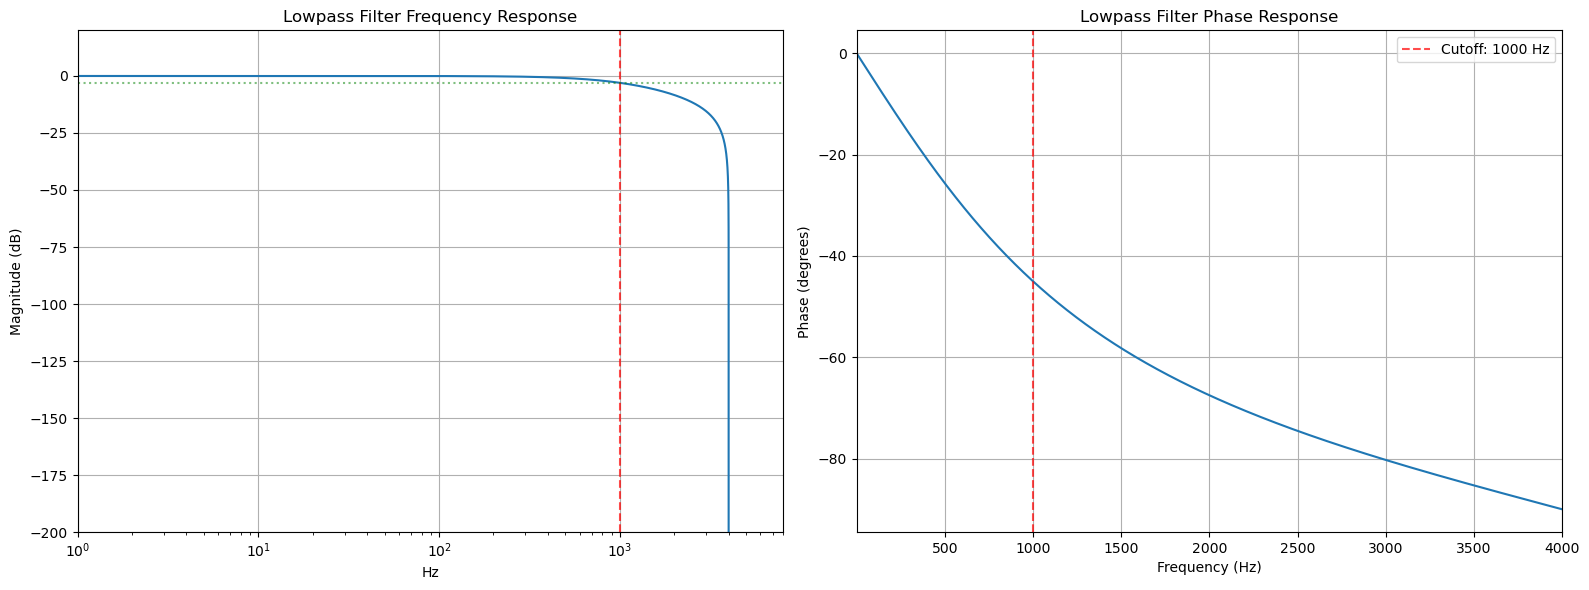

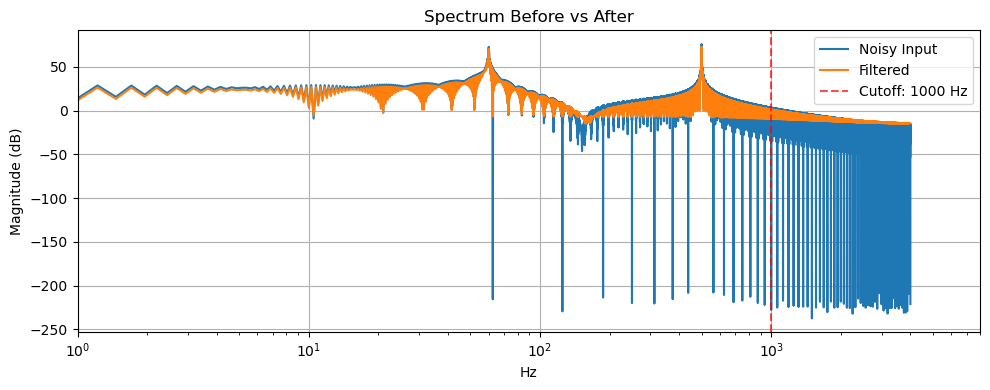

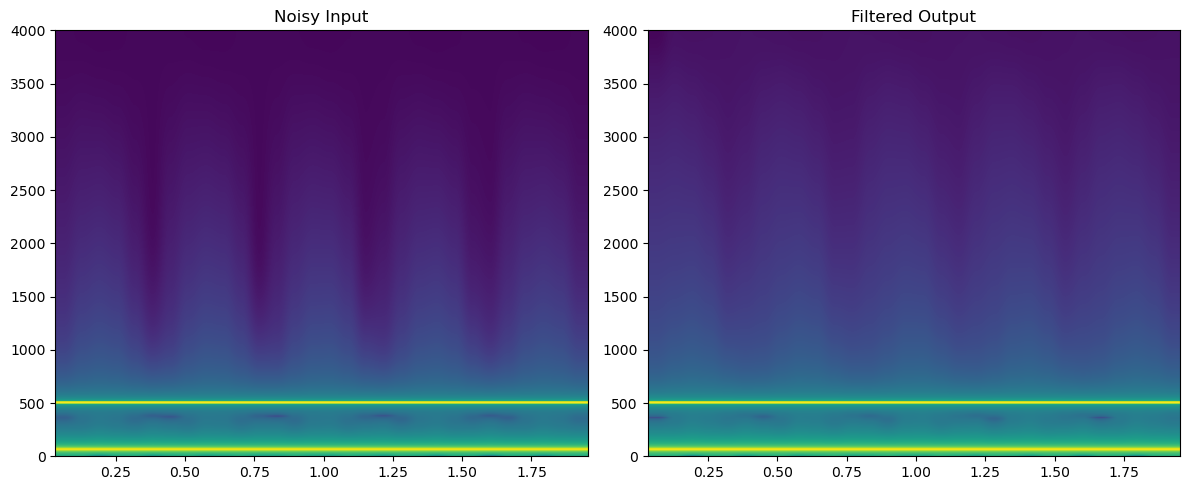

In [9]:
# 1) Magnitude response
n_pts = 4096
w = np.linspace(0, np.pi, n_pts)
z = np.exp(-1j * w)
H = np.polyval(b, z) / np.polyval(a, z)
freqs = w * fs / (2 * np.pi)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.semilogx(freqs, 20*np.log10(np.abs(H)+1e-12))
plt.title(f"{FILTER_TYPE.capitalize()} Filter Frequency Response")
plt.axvline(CUTOFF_HZ, color='r', linestyle='--', alpha=0.7, label=f'Cutoff: {CUTOFF_HZ} Hz')
plt.axhline(-3, color='g', linestyle=':', alpha=0.5, label='-3 dB')
plt.xlabel("Hz")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(1, fs)
plt.ylim(-200, 20)

# 2) Phase
phase = np.unwrap(np.angle(H))
phase_deg = phase * 180 / np.pi
# To make the same as the matlab one
phase_deg = -phase_deg

plt.subplot(1, 2, 2)
plt.plot(freqs, phase_deg)
plt.title(f"{FILTER_TYPE.capitalize()} Filter Phase Response")
plt.axvline(CUTOFF_HZ, color='r', linestyle='--', alpha=0.7, label=f'Cutoff: {CUTOFF_HZ} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees)")
plt.grid(True)
plt.xlim(1, fs/2)
plt.legend()
plt.tight_layout()

# 3) FFT before/after
nfft = 2**15
X = np.fft.rfft(audio_noisy, n=nfft)
Y = np.fft.rfft(filtered, n=nfft)
f = np.fft.rfftfreq(nfft, 1/fs)

plt.figure(figsize=(10, 4))
plt.semilogx(f, 20*np.log10(np.abs(X)+1e-12), label="Noisy Input")
plt.semilogx(f, 20*np.log10(np.abs(Y)+1e-12), label="Filtered")
plt.title("Spectrum Before vs After")
plt.axvline(CUTOFF_HZ, color='r', linestyle='--', alpha=0.7, label=f'Cutoff: {CUTOFF_HZ} Hz')
plt.xlabel("Hz")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()
plt.xlim(1, fs)
plt.tight_layout()

# # 4) Waveforms
# seg = int(0.02 * fs)
# t = np.arange(seg) / fs

# plt.figure(figsize=(10,3))
# plt.plot(t, audio_noisy[:seg], label="Noisy")
# plt.plot(t, filtered[:seg], label="Filtered")
# plt.title("Time Domain (first 20 ms)")
# plt.xlabel("s")
# plt.grid(True)
# plt.legend()

# 5) Spectrograms
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.specgram(audio_noisy, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Noisy Input")
plt.ylim(0,  fs/2)

plt.subplot(1,2,2)
plt.specgram(filtered, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Filtered Output")
plt.ylim(0,  fs/2)

plt.tight_layout()
plt.show()


<h3 style="text-align: center;">Poles & Zeros</h3>

Designing lowpass IIR Butterworth

### Analog Butterworth LOWPASS Filter Transfer Function: H(s) ###
         6627   
      ----------
      1 s + 6627

### Digital Butterworth LOWPASS Filter Transfer Function: H(z) ###
      0.2929 z + 0.2929
      -----------------
         1 z - 0.4142  

Discrete Numerator Coefficients (bz):
   [2.9289e-01 2.9289e-01]

Discrete Denominator Coefficients (az):
   [ 1.         -0.41421356]


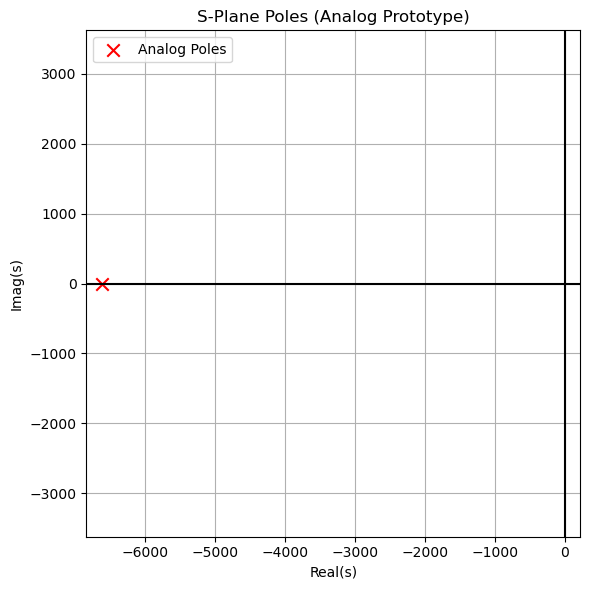

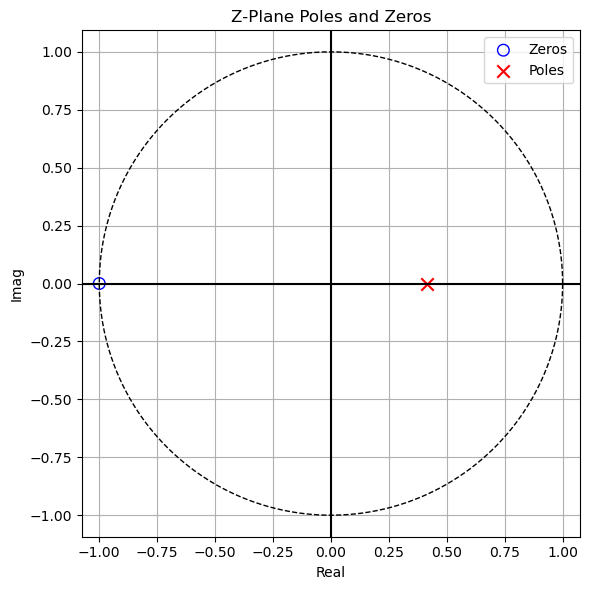

In [10]:
def plot_pz_zplane(b, a):
    """Plot poles & zeros in the Z-plane."""
    zeros = np.roots(b)
    poles = np.roots(a)

    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)

    # Mark poles & zeros
    plt.scatter(zeros.real, zeros.imag, edgecolors='blue',
                facecolors='none', s=70, label="Zeros")
    plt.scatter(poles.real, poles.imag, color='red',
                marker='x', s=80, label="Poles")

    plt.title("Z-Plane Poles and Zeros")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plot_pz_splane(analog_poles):
    """Plot analog poles in the S-plane."""
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.scatter(analog_poles.real, analog_poles.imag,
                color='red', marker='x', s=80, label="Analog Poles")

    plt.title("S-Plane Poles (Analog Prototype)")
    plt.xlabel("Real(s)")
    plt.ylabel("Imag(s)")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
# ============================================================
#          PRINT TRANSFER FUNCTIONS (Z-domain & S-domain)
# ============================================================
def format_poly(coeffs, var):
    terms = []
    deg = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        pwr = deg - i
        if abs(c) < 1e-15: continue
        c_str = f"{c:.4g}"
        if pwr == 0: v_str = ""
        elif pwr == 1: v_str = f" {var}"
        else: v_str = f" {var}^{pwr}"

        if i == 0: terms.append(f"{c_str}{v_str}")
        else:
            op = " + " if c >= 0 else " - "
            terms.append(f"{op}{abs(c):.4g}{v_str}")
    return "".join(terms)



if USE_IIR:
    print(f"Designing {FILTER_TYPE} IIR Butterworth")
    bz, az, as_coeffs, p_an = design_butter_iir(FILTER_TYPE, CUTOFF_HZ, fs, FILTER_ORDER)

    if FILTER_TYPE == "lowpass":
        bs = [as_coeffs[-1]]
    else:
        bs = [1.0] + [0.0] * FILTER_ORDER
    # Make coefficients real (numerical fix)
    bs = np.real(bs)
    as_coeffs = np.real(as_coeffs)
    bz = np.real(bz)
    az = np.real(az)

    # Convert to formatted strings
    s_num = format_poly(bs, "s")
    s_den = format_poly(as_coeffs, "s")
    z_num = format_poly(bz, "z")
    z_den = format_poly(az, "z")

    print(f"\n### Analog Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(s) ###")
    w_s = max(len(s_num), len(s_den))
    print(f"      {s_num.center(w_s)}\n      {'-'*w_s}\n      {s_den.center(w_s)}")

    print(f"\n### Digital Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(z) ###")
    w_z = max(len(z_num), len(z_den))
    print(f"      {z_num.center(w_z)}\n      {'-'*w_z}\n      {z_den.center(w_z)}")

    print("\nDiscrete Numerator Coefficients (bz):")
    print(f"   {np.array2string(bz, formatter={'all':lambda x: f'{x:.4e}'})}")

    print("\nDiscrete Denominator Coefficients (az):")
    print(f"   {az}")

    plot_pz_splane(p_an)
    plot_pz_zplane(bz, az)
else:
    print(f"Designing {FILTER_TYPE} FIR filter")
    b, a = design_fir(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)
    # FIR filter: no analog poles, but plot Z-plane zeros
    plot_pz_zplane(b, a)
